# 1. Import data and libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import talib as ta
from hurst import compute_Hc

In [9]:
df1 = pd.read_csv('ETH-USDT.csv').iloc[-100000:]

# Set the timestamp to be the index for the data
df1 = df1.set_index('Timestamp')

# 2. Convert the Unix epoch time to  datetime

In [10]:
df1.index = pd.to_datetime(df1.index, unit='ms')

# 3. Compute the hurst value for the data

In [11]:
series = df1.Close
H = compute_Hc(series, kind='price')[0]
print("Hurst Exponent H={:.4f}".format(H))

Hurst Exponent H=0.6204


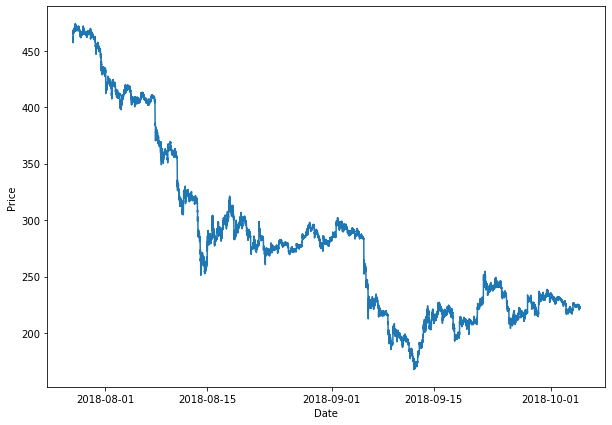

In [12]:
# Let us visualize the data to confirm if it really was trending for the given time frame
plt.figure(figsize=(10, 7))
plt.plot(df1.Close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# 4. Compute the rolling hurst values

In [13]:
df1['H'] = 0

In [14]:
for i in range(240, len(df1)):
    df1.iloc[i, df1.columns.get_loc('H')] = compute_Hc(
        df1.Close.iloc[i-240:i-1], kind='price')[0]

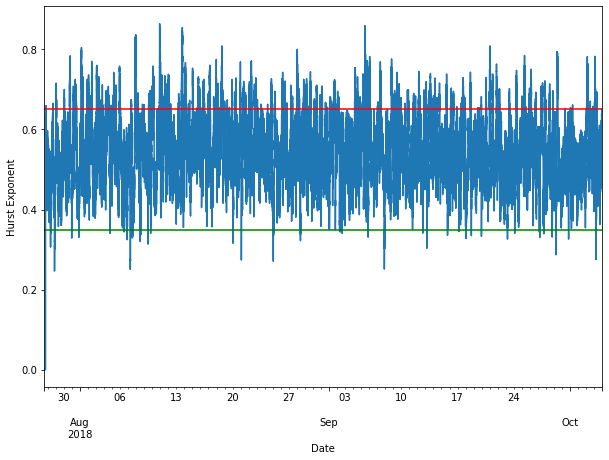

In [15]:
# Let us plot the hurst values to visualize it
# We will be using threshold values of 0.65 and 0.35 to avoid trading for the noise
plt.figure(figsize=(10, 7))
df1.H.plot()
plt.axhline(0.35, color='g')
plt.axhline(0.65, color='r')
plt.xlabel('Date')
plt.ylabel('Hurst Exponent')
plt.show()

# 5. Generate the persitence signals

In [16]:
df1['Signal'] = 0
df1['Signal'] = np.where(df1.H > 0.65, 1, df1.Signal)
df1['Signal'] = np.where(df1.H < 0.35, -1, df1.Signal)

# 6. Compute the RSI

In [17]:
df1['RSI'] = ta.RSI(df1.Close.shift(1).values, 14)

# 7. Compute the market return

In [18]:
# Since we use the previous Close price to calculate the RSI and Hurst values, we use the close prices to calculate
# the market returns during the execution of the strategy.
df1['Return'] = df1.Close.pct_change()

# 8. Compute the strategy returns

In [19]:
df1['StrReturn'] = 0

df1['StrReturn'] = np.where(
    ((df1.RSI > 75) & (df1.Signal == -1)), -df1.Return, df1.StrReturn)

df1['StrReturn'] = np.where(
    ((df1.RSI < 25) & (df1.Signal == -1)), df1.Return, df1.StrReturn)

df1['StrReturn'] = np.where(
    ((df1.RSI > 75) & (df1.Signal == 1)), df1.Return, df1.StrReturn)

df1['StrReturn'] = np.where(
    ((df1.RSI < 25) & (df1.Signal == 1)), -df1.Return, df1.StrReturn)

# 9. Compute the total slipapge cost

In [20]:
# When we execute a strategy based on market orders our strategy can experience a significant slippage,
# if the bid-ask prices are far away. So, we have taken an average bid-ask spread of 0.05 based on the orderbook
# data from cryptoexchanges.

total_slippage_cost = len(df1[df1.StrReturn != 0])*0.05/df1.Close.mean()
total_slippage_cost

0.12242743305187771

In [21]:
Cumulative_Returns = (df1.StrReturn+1).cumprod()

# 10. Plot the cumulative returns of the strategy

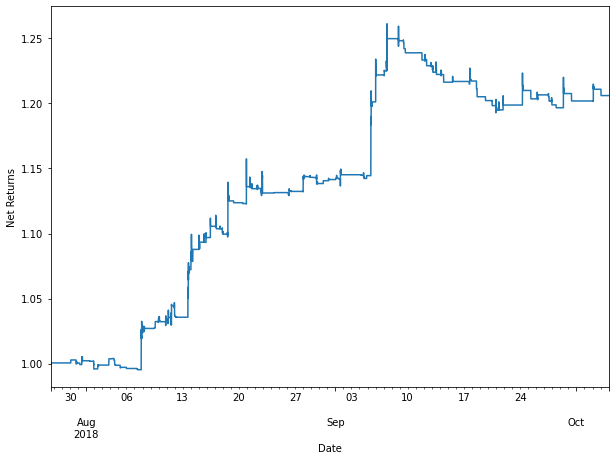

In [22]:
plt.figure(figsize=(10, 7))
Cumulative_Returns.plot()
plt.xlabel('Date')
plt.ylabel('Net Returns')
plt.show()

# 11. Compute the net profit after slippage

In [23]:
Final_percentage_retuns = (Cumulative_Returns.iloc[-1]-total_slippage_cost)*100

In [24]:
Final_percentage_retuns

108.35979062452283